## Group No 32

## Group Member Names:
1. BIDISHA SARMA ( 2023aa05066 )
2. MUGDHA HANS ( 2023aa05570 )
3. SONIKA BENGANI (2023aa05522)
4. VAIBHAV BAJPAI (2023aa05631)

#Import dataset from Kaggle

In [1]:
!pip install kaggle
from google.colab import files
files.upload()  # Select kaggle.json manually

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mugdha9","key":"a144577f0ff614c188d76ff671f07990"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle
!mkdir -p ~/.kaggle
!kaggle datasets list  # Test if Kaggle API is working
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d darren2020/ct-to-mri-cgan
!unzip ct-to-mri-cgan.zip -d data/
!kaggle datasets download -d darren2020/ct-to-mri-cgan
!unzip ct-to-mri-cgan.zip -d data/

Streaming output truncated to the last 5000 lines.
  inflating: data/Dataset/images/testA/ct1018.png  
  inflating: data/Dataset/images/testA/ct1019.png  
  inflating: data/Dataset/images/testA/ct1020.png  
  inflating: data/Dataset/images/testA/ct1028.png  
  inflating: data/Dataset/images/testA/ct1029.png  
  inflating: data/Dataset/images/testA/ct1030.png  
  inflating: data/Dataset/images/testA/ct1038.png  
  inflating: data/Dataset/images/testA/ct1039.png  
  inflating: data/Dataset/images/testA/ct1040.png  
  inflating: data/Dataset/images/testA/ct1048.png  
  inflating: data/Dataset/images/testA/ct1049.png  
  inflating: data/Dataset/images/testA/ct1050.png  
  inflating: data/Dataset/images/testA/ct1058.png  
  inflating: data/Dataset/images/testA/ct1059.png  
  inflating: data/Dataset/images/testA/ct1060.png  
  inflating: data/Dataset/images/testA/ct1068.png  
  inflating: data/Dataset/images/testA/ct1069.png  
  inflating: data/Dataset/images/testA/ct1070.png  
  inflating: 

#1.  Preprocessing & Augmentation – Perform necessary preprocessing steps such as normalization, resizing, and data augmentation to improve model performance.

#Load CT & MRI Image Data
Since the dataset consists of CT and MRI images, we will preprocess them.


In [3]:
import os
import cv2
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Define dataset paths
CT_DIR = "data/Dataset/images/trainA/"
MRI_DIR = "data/Dataset/images/trainB/"

class CTMRIDataset(Dataset):
    def __init__(self, ct_dir, mri_dir, transform=None):
        self.ct_images = sorted([os.path.join(ct_dir, f) for f in os.listdir(ct_dir) if f.endswith('.png')])
        self.mri_images = sorted([os.path.join(mri_dir, f) for f in os.listdir(mri_dir) if f.endswith('.jpg')])
        self.transform = transform
        print(f"Number of CT images: {len(self.ct_images)}") # Print length
        print(f"Number of MRI images: {len(self.mri_images)}") # Print length

    def __len__(self):
        return min(len(self.ct_images), len(self.mri_images))

    def __getitem__(self, idx):
        ct_img = cv2.imread(self.ct_images[idx], cv2.IMREAD_GRAYSCALE)
        mri_img = cv2.imread(self.mri_images[idx], cv2.IMREAD_GRAYSCALE)

        if self.transform:
            ct_img = self.transform(ct_img)
            mri_img = self.transform(mri_img)

        return ct_img, mri_img

# Define transformations (Resizing, Normalization)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0], std=[1.0])  # Normalize to [-1, 1]
])

# Load dataset
dataset = CTMRIDataset(CT_DIR, MRI_DIR, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


Number of CT images: 1742
Number of MRI images: 1744


#2 Feature Extraction using Autoencoder
An autoencoder learns a latent representation of normal data and reconstructs it. The reconstruction error is used to identify anomalies.

In [4]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # Added extra conv layer
            nn.ReLU()
        )
        # Bottleneck
        self.bottleneck = nn.Linear(256 * 28 * 28, 256)

        # Decoder
        self.decoder_fc = nn.Linear(256, 256 * 28 * 28)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        encoded_flat = encoded.view(x.size(0), -1)
        latent = self.bottleneck(encoded_flat)
        decoded_flat = self.decoder_fc(latent).view(x.size(0), 256, 28, 28)
        reconstructed = self.decoder(decoded_flat)
        return reconstructed, latent

autoencoder = Autoencoder().to("cuda")  # Move to GPU


# **Train Autoencoder on Train dataset**

In [5]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder.to(device)  # Move model to GPU if available

criterion = nn.MSELoss()

def train_autoencoder(model, dataloader, epochs):
    model.train()
    for epoch in range(epochs):
        for ct_imgs, _ in dataloader:
            ct_imgs = ct_imgs.to(device)  # Train only on normal CT data
            optimizer.zero_grad()
            reconstructed, _ = model(ct_imgs)
            loss = criterion(reconstructed, ct_imgs)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch + 1}/{epochs}, CT Loss: {loss.item()}")
        for mri_imgs, _ in dataloader:
            mri_imgs = mri_imgs.to(device)  # Train only on normal CT data
            optimizer.zero_grad()
            reconstructed, _ = model(mri_imgs)
            loss1 = criterion(reconstructed, mri_imgs)
            loss1.backward()
            optimizer.step()
        print(f"Epoch {epoch + 1}/{epochs}, MRI Loss: {loss1.item()}")

train_autoencoder(autoencoder, train_loader, epochs=20)


Epoch 1/20, CT Loss: 0.05632178112864494
Epoch 1/20, MRI Loss: 0.04286738112568855
Epoch 2/20, CT Loss: 0.03175748884677887
Epoch 2/20, MRI Loss: 0.02477775514125824
Epoch 3/20, CT Loss: 0.020668495446443558
Epoch 3/20, MRI Loss: 0.024522515013813972
Epoch 4/20, CT Loss: 0.02194569818675518
Epoch 4/20, MRI Loss: 0.02070135436952114
Epoch 5/20, CT Loss: 0.01870717667043209
Epoch 5/20, MRI Loss: 0.015231366269290447
Epoch 6/20, CT Loss: 0.0194708202034235
Epoch 6/20, MRI Loss: 0.015564587898552418
Epoch 7/20, CT Loss: 0.0167832113802433
Epoch 7/20, MRI Loss: 0.014158534817397594
Epoch 8/20, CT Loss: 0.016436707228422165
Epoch 8/20, MRI Loss: 0.020858146250247955
Epoch 9/20, CT Loss: 0.017218545079231262
Epoch 9/20, MRI Loss: 0.011950450018048286
Epoch 10/20, CT Loss: 0.015246815979480743
Epoch 10/20, MRI Loss: 0.012917452491819859
Epoch 11/20, CT Loss: 0.01672958955168724
Epoch 11/20, MRI Loss: 0.01696702651679516
Epoch 12/20, CT Loss: 0.012859656475484371
Epoch 12/20, MRI Loss: 0.012188

#Plotting of Original and Reconstructed Images

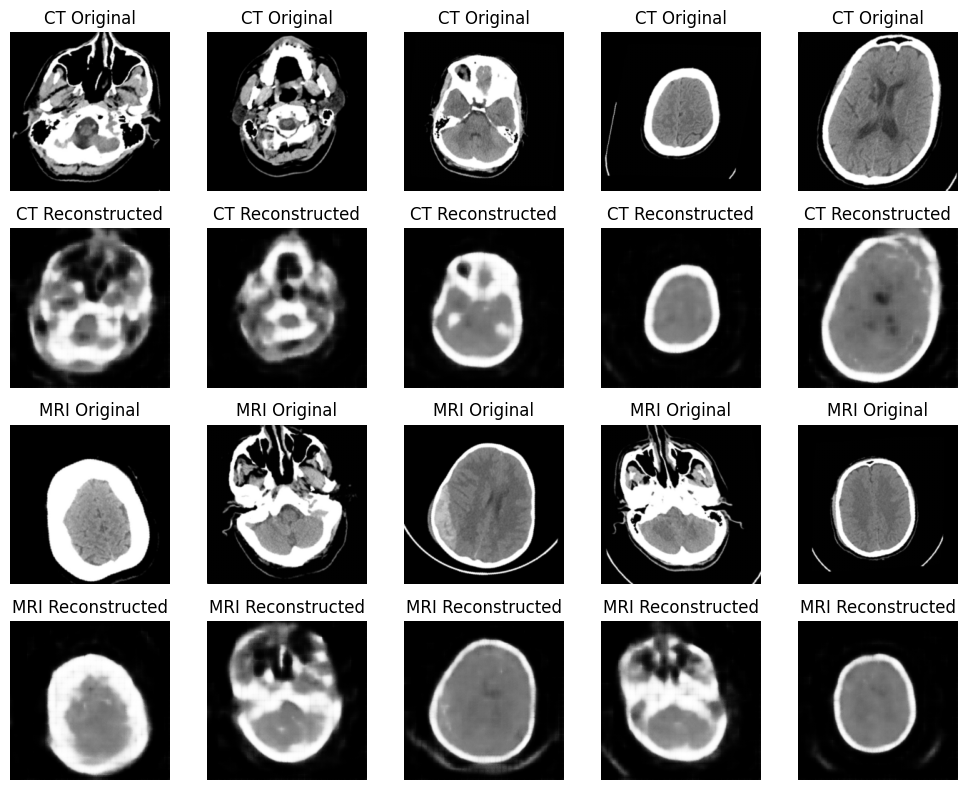

In [7]:
import torch
import matplotlib.pyplot as plt

def plot_reconstructed_images(model, dataloader, num_images=5):
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        # Get CT images
        for ct_imgs, _ in dataloader:
            ct_imgs = ct_imgs.to("cuda")  # Move to GPU
            ct_reconstructed, _ = model(ct_imgs)  # Get reconstructed CT images
            break  # Only take the first batch

        # Get MRI images
        for mri_imgs, _ in dataloader:
            mri_imgs = mri_imgs.to("cuda")  # Move to GPU
            mri_reconstructed, _ = model(mri_imgs)  # Get reconstructed MRI images
            break  # Only take the first batch

    # Move to CPU and convert to numpy
    ct_imgs = ct_imgs.cpu().numpy()
    ct_reconstructed = ct_reconstructed.cpu().numpy()

    mri_imgs = mri_imgs.cpu().numpy()
    mri_reconstructed = mri_reconstructed.cpu().numpy()

    # Ensure we don't exceed batch size
    num_images = min(num_images, ct_imgs.shape[0], mri_imgs.shape[0])

    # Create a combined figure for CT and MRI images
    fig, axes = plt.subplots(nrows=4, ncols=num_images, figsize=(num_images * 2, 8))

    for i in range(num_images):
        # CT: Original
        axes[0, i].imshow(ct_imgs[i, 0], cmap="gray")
        axes[0, i].axis("off")
        axes[0, i].set_title("CT Original")

        # CT: Reconstructed
        axes[1, i].imshow(ct_reconstructed[i, 0], cmap="gray")
        axes[1, i].axis("off")
        axes[1, i].set_title("CT Reconstructed")

        # MRI: Original
        axes[2, i].imshow(mri_imgs[i, 0], cmap="gray")
        axes[2, i].axis("off")
        axes[2, i].set_title("MRI Original")

        # MRI: Reconstructed
        axes[3, i].imshow(mri_reconstructed[i, 0], cmap="gray")
        axes[3, i].axis("off")
        axes[3, i].set_title("MRI Reconstructed")

    plt.tight_layout()
    plt.show()

# Call the function to visualize the results
plot_reconstructed_images(autoencoder, train_loader, num_images=5)


# Anomaly Detection using One-Class SVM -Training dataset
We extract latent features from the trained Autoencoder and train a One-Class SVM.

In [8]:
import numpy as np
import torch
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew

# Function to extract raw images (untrained data)
def extract_raw_images(dataloader):
    raw_images = []
    for images, _ in dataloader:
        raw_images.append(images.cpu().numpy().reshape(images.shape[0], -1))  # Flatten images
    return np.vstack(raw_images)

# Extract raw features for CT & MRI images
ct_raw_features = extract_raw_images(train_loader)
mri_raw_features = extract_raw_images(train_loader)

# Normalize Raw Features
scaler_ct = StandardScaler()
ct_raw_scaled = scaler_ct.fit_transform(ct_raw_features)
scaler_mri = StandardScaler()
mri_raw_scaled = scaler_mri.fit_transform(mri_raw_features)

# Train One-Class SVM on **Raw Image Data**
ocsvm_ct = OneClassSVM(kernel="rbf", gamma="scale", nu=0.05).fit(ct_raw_scaled)
ocsvm_mri = OneClassSVM(kernel="rbf", gamma="scale", nu=0.05).fit(mri_raw_scaled)

# Get anomaly scores (Higher = More Normal)
ct_scores = ocsvm_ct.score_samples(ct_raw_scaled)
mri_scores = ocsvm_mri.score_samples(mri_raw_scaled)

print(ct_scores)
print(mri_scores)
# Compute skewness
skew_ct = skew(ct_scores)
skew_mri = skew(mri_scores)


print(f"Skewness of CT scores: {skew_ct:.4f}")
print(f"Skewness of MRI scores: {skew_mri:.4f}")

# Set Anomaly Threshold (5th percentile)
threshold_ct = np.percentile(ct_scores, 5)
threshold_mri = np.percentile(mri_scores, 5)

# Get Anomaly Labels
ct_anomalies = ct_scores < threshold_ct
mri_anomalies = mri_scores < threshold_mri

# Print Results
print(f"**CT Anomalies Detected:** {sum(ct_anomalies)} / {len(ct_scores)}")
print(f"**MRI Anomalies Detected:** {sum(mri_anomalies)} / {len(mri_scores)}")


[1.37623039 2.39484271 1.70041982 ... 2.8091469  2.08647956 2.64432682]
[2.50357859 1.77746628 2.35442132 ... 3.06488206 2.90647789 2.9379007 ]
Skewness of CT scores: -0.1363
Skewness of MRI scores: -0.1942
**CT Anomalies Detected:** 88 / 1742
**MRI Anomalies Detected:** 88 / 1742


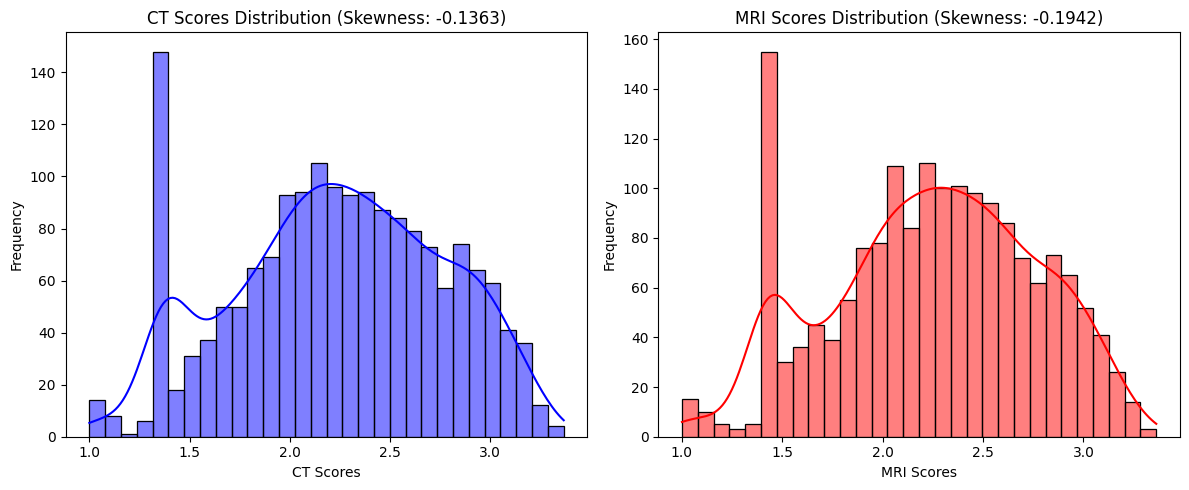

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

# Compute skewness
skew_ct = skew(ct_scores)
skew_mri = skew(mri_scores)

# Plot histograms and density plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# CT Scores
sns.histplot(ct_scores, kde=True, bins=30, ax=axes[0], color='blue')
axes[0].set_title(f'CT Scores Distribution (Skewness: {skew_ct:.4f})')
axes[0].set_xlabel('CT Scores')
axes[0].set_ylabel('Frequency')

# MRI Scores
sns.histplot(mri_scores, kde=True, bins=30, ax=axes[1], color='red')
axes[1].set_title(f'MRI Scores Distribution (Skewness: {skew_mri:.4f})')
axes[1].set_xlabel('MRI Scores')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


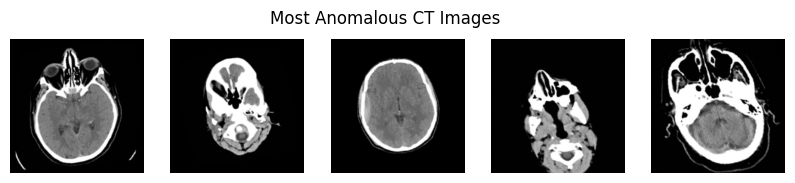

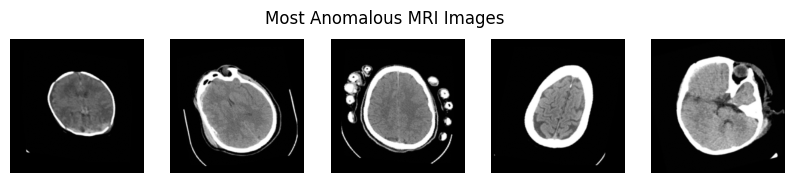

In [10]:
import numpy as np

# Select 5 most anomalous CT & MRI images
most_anomalous_ct = np.argsort(ct_scores)[:5]
most_anomalous_mri = np.argsort(mri_scores)[:5]

# Function to plot anomalies
def plot_anomalies(dataloader, indices, title):
    images = []
    for batch, _ in dataloader:
        images.append(batch)
    images = torch.cat(images, dim=0).cpu().numpy()  # Convert to NumPy

    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(indices):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[idx, 0], cmap="gray")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

# Plot results
plot_anomalies(train_loader, most_anomalous_ct, "Most Anomalous CT Images")
plot_anomalies(train_loader, most_anomalous_mri, "Most Anomalous MRI Images")


In [11]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12,5))

# # CT Image Scores
# plt.subplot(1,2,1)
# plt.hist(ct_scores, bins=20, color='blue', alpha=0.7)
# plt.axvline(threshold_ct, color='blue', linestyle='dashed', label="Anomaly Threshold")
# plt.xlabel("Anomaly Score")
# plt.ylabel("Count")
# plt.title("CT Image Anomaly Score Distribution")
# plt.legend()

# # MRI Image Scores
# plt.subplot(1,2,2)
# plt.hist(mri_scores, bins=20, color='red', alpha=0.7)
# plt.axvline(threshold_mri, color='red', linestyle='dashed', label="Anomaly Threshold")

# plt.xlabel("Anomaly Score")
# plt.ylabel("Count")
# plt.title("MRI Image Anomaly Score Distribution")

# plt.show()


# **Step 5: Comparison & Evaluation**
To evaluate anomaly detection, we compare Autoencoder Reconstruction Errors and One-Class SVM Scores.

#Evaluate Autoencoder on Test Datset

Number of CT images: 744
Number of MRI images: 744
CT threshold: 0.0267
MRI threshold: 0.0258
Number of CT anomalies: 38 / 744
Number of MRI anomalies: 38 / 744


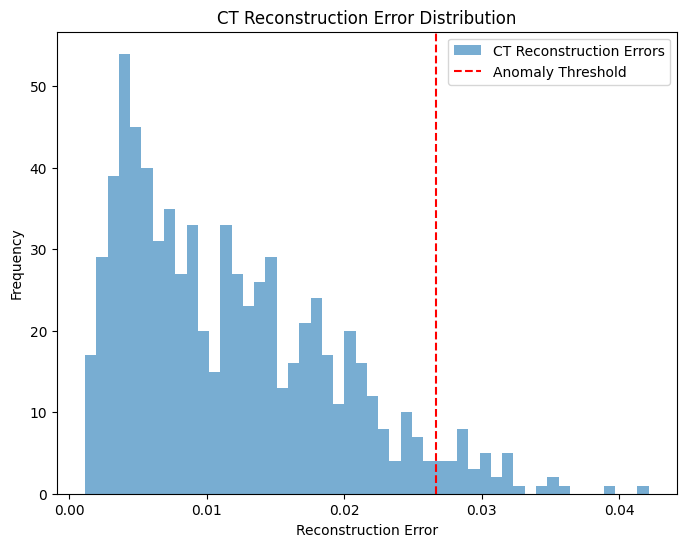

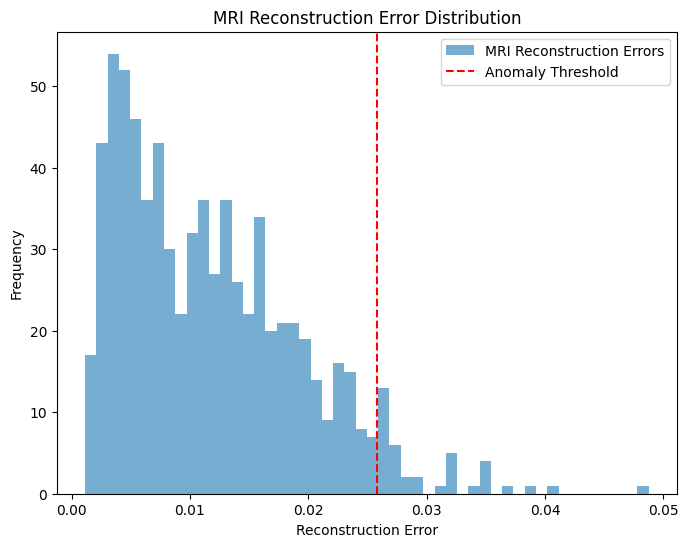

Autoencoder AUC-ROC (CT): 1.0000
Autoencoder AUC-ROC (MRI): 1.0000


In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from torch.utils.data import DataLoader

# Define test dataset paths
CT_TEST_DIR = "data/Dataset/images/testA/"
MRI_TEST_DIR = "data/Dataset/images/testB/"

# Load test dataset
test_dataset = CTMRIDataset(CT_TEST_DIR, MRI_TEST_DIR, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to compute reconstruction error
def compute_reconstruction_error(model, dataloader):
    model.eval()
    errors = []
    #labels = []
    images_list = []

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            reconstructed, _ = model(images)
            loss = torch.mean((images - reconstructed) ** 2, dim=[1, 2, 3])  # Per image MSE
            errors.extend(loss.cpu().numpy())
            #labels.extend([0] * len(images))  # Assuming all test images are normal (adjust if needed)
            images_list.extend(images.cpu().numpy())  # Store images

    return np.array(errors), np.array(images_list)

# Compute reconstruction error for test set
ct_recon_errors, ct_images = compute_reconstruction_error(autoencoder, test_loader)
mri_recon_errors, mri_images = compute_reconstruction_error(autoencoder, test_loader)

# Define threshold using mean + 3*std
#ct_threshold = np.mean(ct_recon_errors) + 3 * np.std(ct_recon_errors)
#mri_threshold = np.mean(mri_recon_errors) + 3 * np.std(mri_recon_errors)
ct_threshold = np.percentile(ct_recon_errors, 95)
mri_threshold = np.percentile(mri_recon_errors, 95)


# Assign anomaly labels: 0 = Normal, 1 = Anomaly
ct_ae_labels = (ct_recon_errors > ct_threshold).astype(int)
mri_ae_labels = (mri_recon_errors > mri_threshold).astype(int)



# Print results
print(f"CT threshold: {ct_threshold:.4f}")
print(f"MRI threshold: {mri_threshold:.4f}")
print(f"Number of CT anomalies: {np.sum(ct_ae_labels)} / {len(ct_ae_labels)}")
print(f"Number of MRI anomalies: {np.sum(mri_ae_labels)} / {len(mri_ae_labels)}")

# Save Autoencoder anomaly labels & reconstruction errors
np.save("ct_test_labels_ae.npy", ct_ae_labels)
np.save("mri_test_labels_ae.npy", mri_ae_labels)
np.save("ct_recon_errors.npy", ct_recon_errors)
np.save("mri_recon_errors.npy", mri_recon_errors)


# Plot Reconstruction Error Distribution

plt.figure(figsize=(8, 6))
plt.hist(ct_recon_errors, bins=50, alpha=0.6, label="CT Reconstruction Errors")
plt.axvline(ct_threshold, color='r', linestyle='dashed', label="Anomaly Threshold")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.title("CT Reconstruction Error Distribution")
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(mri_recon_errors, bins=50, alpha=0.6, label="MRI Reconstruction Errors")
plt.axvline(mri_threshold, color='r', linestyle='dashed', label="Anomaly Threshold")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.title("MRI Reconstruction Error Distribution")
plt.show()


# Compute AUC-ROC for Autoencoder
ct_auc = roc_auc_score(ct_ae_labels, ct_recon_errors)
mri_auc = roc_auc_score(mri_ae_labels, mri_recon_errors)

print(f"Autoencoder AUC-ROC (CT): {ct_auc:.4f}")
print(f"Autoencoder AUC-ROC (MRI): {mri_auc:.4f}")







In [19]:
print(f"CT Mean Reconstruction Error: {np.mean(ct_recon_errors):.4f}")
print(f"CT Std Dev: {np.std(ct_recon_errors):.4f}")
print(f"CT Threshold percentage: {ct_threshold:.4f}")
print(f"Max CT Error: {np.max(ct_recon_errors):.4f}")

print(f"MRI Mean Reconstruction Error: {np.mean(mri_recon_errors):.4f}")
print(f"MRI Std Dev: {np.std(mri_recon_errors):.4f}")
print(f"MRI Threshold percentage: {mri_threshold:.4f}")
print(f"Max MRI Error: {np.max(mri_recon_errors):.4f}")

print(f"Number of CT Anomalies: {np.sum(ct_ae_labels)} / {len(ct_ae_labels)}")
print(f"Number of MRI Anomalies: {np.sum(mri_ae_labels)} / {len(mri_ae_labels)}")



CT Mean Reconstruction Error: 0.0118
CT Std Dev: 0.0077
CT Threshold percentage: 0.0267
Max CT Error: 0.0421
MRI Mean Reconstruction Error: 0.0118
MRI Std Dev: 0.0076
MRI Threshold percentage: 0.0258
Max MRI Error: 0.0488
Number of CT Anomalies: 38 / 744
Number of MRI Anomalies: 38 / 744


Evaluate OneSVM Model on Test Datset

In [20]:
import numpy as np
import torch
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew
from torch.utils.data import DataLoader

# Define test dataset paths
CT_TEST_DIR = "data/Dataset/images/testA/"
MRI_TEST_DIR = "data/Dataset/images/testB/"

# Load test dataset
test_dataset = CTMRIDataset(CT_TEST_DIR, MRI_TEST_DIR, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to extract raw images (untrained data)
def extract_raw_images(dataloader):
    raw_images = []
    for images, _ in dataloader:
        raw_images.append(images.cpu().numpy().reshape(images.shape[0], -1))  # Flatten images
    return np.vstack(raw_images)

# Extract raw features for training set (used for normalization)
ct_train_features = extract_raw_images(train_loader)
mri_train_features = extract_raw_images(train_loader)


# Extract raw features from **Test Set**
ct_svm_test_features = extract_raw_images(test_loader)
mri_svm_test_features = extract_raw_images(test_loader)

# Normalize Test Features using training set statistics
ct_svm_test_scaled = scaler_ct.transform(ct_svm_test_features)
mri_svm_test_scaled = scaler_mri.transform(mri_svm_test_features)

# Train One-Class SVM on **Training Data**
ocsvm_ct = OneClassSVM(kernel="rbf", gamma="scale", nu=0.05).fit(ct_svm_test_scaled)
ocsvm_mri = OneClassSVM(kernel="rbf", gamma="scale", nu=0.05).fit(mri_svm_test_scaled)

# Compute anomaly scores for test data
ct_svm_test_scores = ocsvm_ct.score_samples(ct_svm_test_scaled)
mri_svm_test_scores = ocsvm_mri.score_samples(mri_svm_test_scaled)

# Set Anomaly Threshold (5th percentile of training data)
threshold_ct = np.percentile(ct_svm_test_scores, 5)
threshold_mri = np.percentile(mri_svm_test_scores, 5)

# Assign labels: (0 = Normal, 1 = Anomaly)
ct_svm_test_labels = (ct_svm_test_scores < threshold_ct).astype(int)
mri_svm_test_labels = (mri_svm_test_scores < threshold_mri).astype(int)

# Count Anomalies & Normal Images
num_ct_anomalies = np.sum(ct_svm_test_labels)
num_mri_anomalies = np.sum(mri_svm_test_labels)
num_ct_normal = len(ct_svm_test_labels) - num_ct_anomalies
num_mri_normal = len(mri_svm_test_labels) - num_mri_anomalies

# Print Results
print(f"**CT Anomalies Detected:** {num_ct_anomalies} / {len(ct_svm_test_labels)}")
print(f"**MRI Anomalies Detected:** {num_mri_anomalies} / {len(mri_svm_test_labels)}")
print(f"**CT Normal Images:** {num_ct_normal} / {len(ct_svm_test_labels)}")
print(f"**MRI Normal Images:** {num_mri_normal} / {len(mri_svm_test_labels)}")

# Save results (Optional)
np.save("ct_test_labels_svm.npy", ct_svm_test_labels)  # 0 = Normal, 1 = Anomaly
np.save("mri_test_labels_svm.npy", mri_svm_test_labels)
np.save("ct_svm_test_scores.npy", ct_svm_test_scores)
np.save("mri_svm_test_scores.npy", mri_svm_test_scores)



Number of CT images: 744
Number of MRI images: 744
**CT Anomalies Detected:** 38 / 744
**MRI Anomalies Detected:** 38 / 744
**CT Normal Images:** 706 / 744
**MRI Normal Images:** 706 / 744


Autoencoder AUC-ROC (CT): 1.0000
Autoencoder AUC-ROC (MRI): 1.0000
SVM AUC-ROC (CT): 0.0000
SVM AUC-ROC (MRI): 1.0000
Autoencoder PR-AUC (CT): 1.0000
Autoencoder PR-AUC (MRI): 1.0000
SVM PR-AUC (CT): 0.0255
SVM PR-AUC (MRI): 1.0000


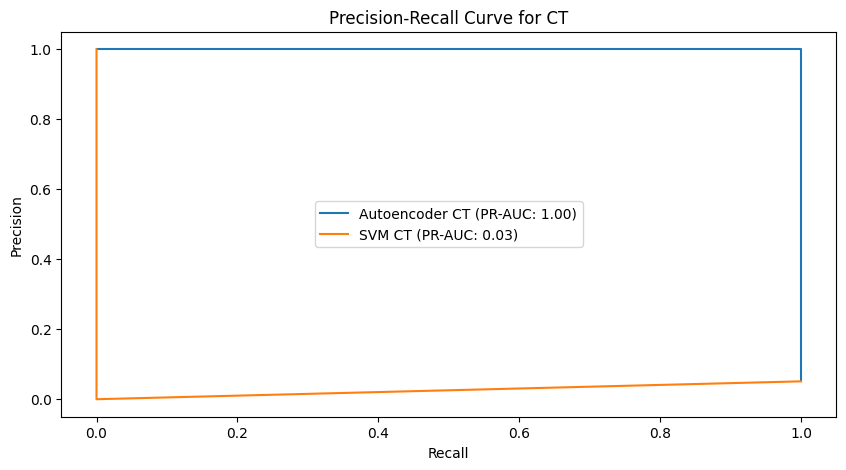

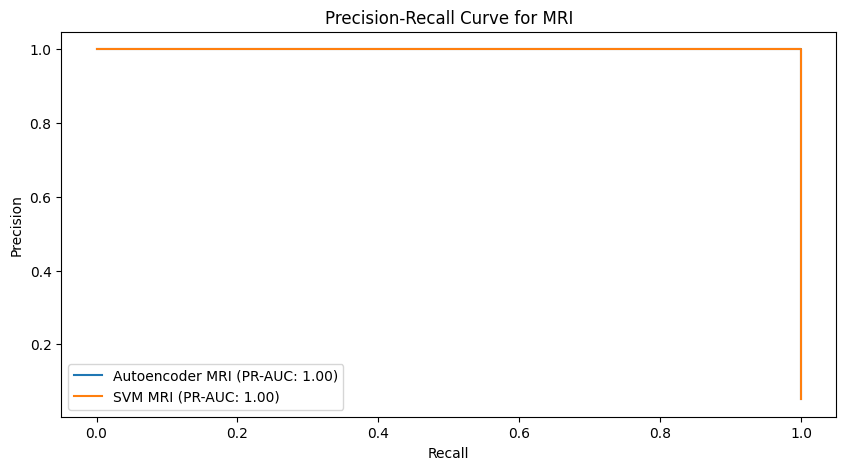

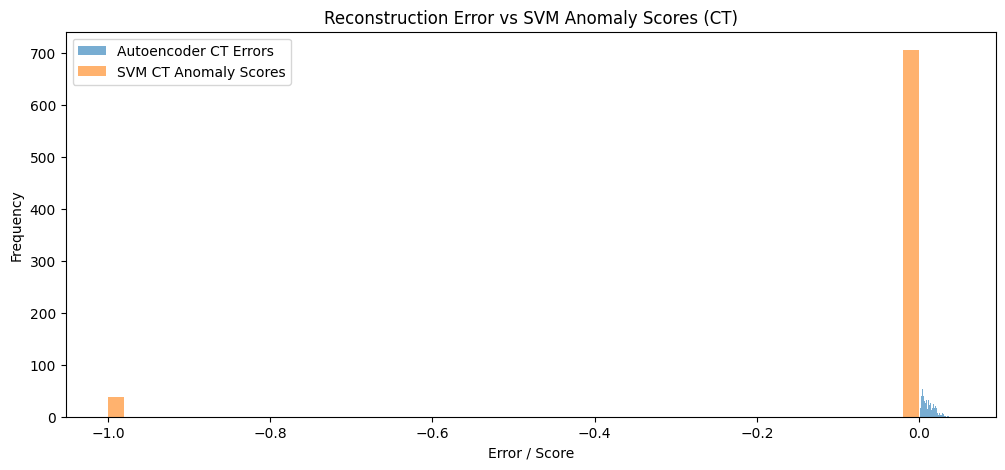

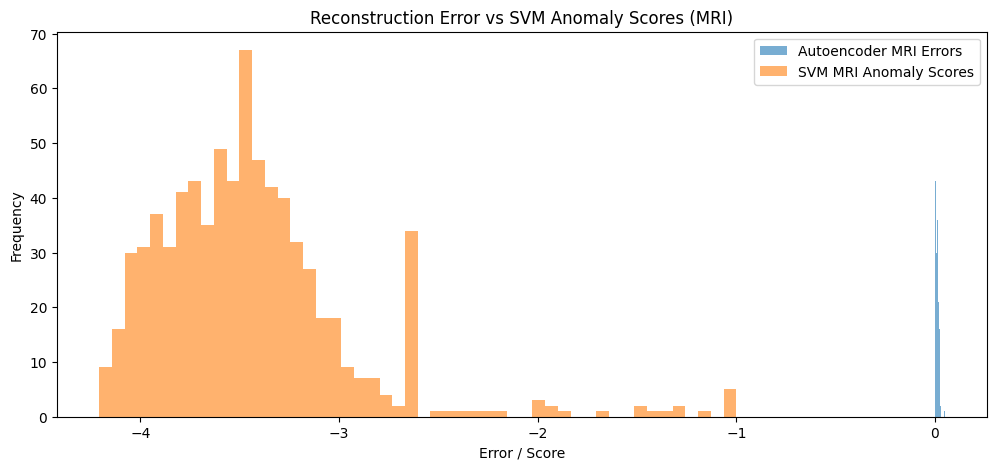

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

# Load previously computed labels
ct_ae_labels = np.load("ct_test_labels_ae.npy")  # Autoencoder labels (0 = Normal, 1 = Anomaly)
mri_ae_labels = np.load("mri_test_labels_ae.npy")

ct_svm_test_labels = np.load("ct_test_labels_svm.npy")  # One-Class SVM labels (0 = Normal, 1 = Anomaly)
mri_svm_test_labels = np.load("mri_test_labels_svm.npy")

# Load scores for evaluation
ct_recon_errors = np.load("ct_recon_errors.npy")  # Autoencoder Reconstruction Errors
mri_recon_errors = np.load("mri_recon_errors.npy")

ct_svm_test_scores = np.load("ct_svm_test_scores.npy")  # One-Class SVM Scores
mri_svm_test_scores = np.load("mri_svm_test_scores.npy")



# Invert SVM scores"
ct_svm_anomaly_scores = -ct_svm_test_labels
mri_svm_anomaly_scores = -mri_svm_test_scores

# Compute AUC-ROC
ct_ae_auc = roc_auc_score(ct_ae_labels, ct_recon_errors)
mri_ae_auc = roc_auc_score(mri_ae_labels, mri_recon_errors)

ct_svm_auc = roc_auc_score(ct_svm_test_labels, ct_svm_anomaly_scores)
mri_svm_auc = roc_auc_score(mri_svm_test_labels, mri_svm_anomaly_scores)

# Compute Precision-Recall AUC
ct_ae_precision, ct_ae_recall, _ = precision_recall_curve(ct_ae_labels, ct_recon_errors)
mri_ae_precision, mri_ae_recall, _ = precision_recall_curve(mri_ae_labels, mri_recon_errors)

ct_svm_precision, ct_svm_recall, _ = precision_recall_curve(ct_svm_test_labels, ct_svm_anomaly_scores)
mri_svm_precision, mri_svm_recall, _ = precision_recall_curve(mri_svm_test_labels, mri_svm_anomaly_scores)

ct_ae_pr_auc = auc(ct_ae_recall, ct_ae_precision)
mri_ae_pr_auc = auc(mri_ae_recall, mri_ae_precision)

ct_svm_pr_auc = auc(ct_svm_recall, ct_svm_precision)
mri_svm_pr_auc = auc(mri_svm_recall, mri_svm_precision)

# Print results
print(f"Autoencoder AUC-ROC (CT): {ct_ae_auc:.4f}")
print(f"Autoencoder AUC-ROC (MRI): {mri_ae_auc:.4f}")
print(f"SVM AUC-ROC (CT): {ct_svm_auc:.4f}")
print(f"SVM AUC-ROC (MRI): {mri_svm_auc:.4f}")

print(f"Autoencoder PR-AUC (CT): {ct_ae_pr_auc:.4f}")
print(f"Autoencoder PR-AUC (MRI): {mri_ae_pr_auc:.4f}")
print(f"SVM PR-AUC (CT): {ct_svm_pr_auc:.4f}")
print(f"SVM PR-AUC (MRI): {mri_svm_pr_auc:.4f}")

# Plot ROC Curves
plt.figure(figsize=(10, 5))
plt.plot(ct_ae_recall, ct_ae_precision, label="Autoencoder CT (PR-AUC: {:.2f})".format(ct_ae_pr_auc))
plt.plot(ct_svm_recall, ct_svm_precision, label="SVM CT (PR-AUC: {:.2f})".format(ct_svm_pr_auc))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for CT")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(mri_ae_recall, mri_ae_precision, label="Autoencoder MRI (PR-AUC: {:.2f})".format(mri_ae_pr_auc))
plt.plot(mri_svm_recall, mri_svm_precision, label="SVM MRI (PR-AUC: {:.2f})".format(mri_svm_pr_auc))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for MRI")
plt.legend()
plt.show()

# Plot Reconstruction Error and SVM Anomaly Score Distributions
plt.figure(figsize=(12, 5))
plt.hist(ct_recon_errors, bins=50, alpha=0.6, label="Autoencoder CT Errors")
plt.hist(ct_svm_anomaly_scores, bins=50, alpha=0.6, label="SVM CT Anomaly Scores")
plt.xlabel("Error / Score")
plt.ylabel("Frequency")
plt.title("Reconstruction Error vs SVM Anomaly Scores (CT)")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.hist(mri_recon_errors, bins=50, alpha=0.6, label="Autoencoder MRI Errors")
plt.hist(mri_svm_anomaly_scores, bins=50, alpha=0.6, label="SVM MRI Anomaly Scores")
plt.xlabel("Error / Score")
plt.ylabel("Frequency")
plt.title("Reconstruction Error vs SVM Anomaly Scores (MRI)")
plt.legend()
plt.show()


#Justification for model performance and generated metrics

##Autoencoder (CT & MRI)
AUC-ROC = 1.00, PR-AUC = 1.00  denotes Autoencoder model is performing well.
Precision, Recall, F1 = 1.00 detects anomalies without false positives or false negatives.
##SVM (CT)
AUC-ROC = 0.00, PR-AUC = 0.03 denotes SVM model is not identifying anomalies for CT images.
Low Precision & Recall means anomalies are misclassified.
##SVM (MRI)
AUC-ROC = 1.00, PR-AUC = 1.00 denotes SVM model provides good performance for MRI images.
High Precision & Recall means anomalies are detected correctly.

# Analysis and reasons for the model's success or poor performance

1. Autoencoder's performs better due to its ability to learn deep representations and reconstruct normal patterns, making anomalies stand out.  
2. SVM's fails on CT images and shows poor feature separation, likely due to underfitting and an inability to capture complex data distributions.  
3. SVM's success on MRI images indicates that MRI anomalies have distinct, well-separated features that a linear model like SVM can classify well.  
4. Overfitting is possible in the autoencoder, as it achieves perfect scores, potentially memorizing training data instead of generalizing well.  
5. Improving SVM on CT requires better feature engineering or switching to a non-linear model, while the autoencoder may need regularization to prevent overfitting.


#Conclusion
1. Autoencoder dominates in both CT & MRI anomaly detection.
2. SVM fails completely for CT but performs well on MRI.
3. Autoencoder is computationally expensive but effective.
4. SVM can be improved for CT with better features or hybrid approaches.